In [259]:
import requests

import json
from io import BytesIO, StringIO
from zipfile import ZipFile

import pprint
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np

In [2]:
def get_data(url: str, to_json=True, decode=True) -> list:
    """
    :param url:
    :return: list of dicts (json object)
    """
    resp = requests.get(url).content
    zipfile = ZipFile(BytesIO(resp))

    zip_files = zipfile.namelist()
    assert len(zip_files) == 1

    data = zipfile.open(zip_files[0]).read()
    
    if decode is True:
        data = data.decode('WINDOWS-1251')

    if to_json is True:
        data = json.loads(data)

    return data

In [385]:
urls = {
    'childens_clinic': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=861920',
        'format': 'json',
        'description': 'Поликлиническая помощь детям'
    },
    'adult_clinic': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=887773',
        'format': 'json',
        'description': '# Поликлиническая помощь взрослым'
    },
    'social_food': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=871418',
        'format': 'json',
        'description': '# Общественное питание в г.Москве'
    },
    'education': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=888685',
        'format': 'json',
        'description': '# Образовательные учреждения города Москвы'
    },
    'wifi': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=864835',
        'format': 'xlsx',
        'description': '# Городской Wi-Fi (xlsx)'
    },
    'rescue_garrison': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=868132',
        'format': 'xlsx',
        'description': '# Данные о вызовах пожарно-спасательного гарнизона в г. Москва (xlsx)'
    },
    'regions': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=2044',
        'format': 'xlsx',
        'description': '# районы + улицы (xlsx)'
    },
    'swimming_pool': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=894596',
        'format': 'json',
        'description': 'Данные о бассейнах (крытых)'
    },
    'emergency_services': {
        'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=402655',
        'format': 'xlsx',
        'description': 'Аварийные службы по ремонту водопровода, канализации, освещения и отопления в многоквартирных домах'
    }
}

In [4]:
def mul_bool(array):
    assert len(array) > 1
    row = array[0]
    for i in array[1:]:
        row = row * i
    return row

def detect_district(address, regions):
    indexes = []
    for i in address.split(','):
        indexes.append(regions.Address.str.contains(i.strip()).values)
    if address.count(',') == 0:
        result_indexes = indexes[0]
    else:
        result_indexes = mul_bool(indexes)
    if regions[result_indexes].District.shape[0] == 0:
        # ничего не нашлось
        for i, addr_substr in enumerate(address.split(',')):
            if addr_substr.isnumeric() is False:
                return regions[indexes[i]].District.unique().tolist()
        
    return regions[result_indexes].District.unique().tolist()


In [209]:
regions['District'] = regions.District.apply(lambda x: x.strip())

In [6]:
raw_regions = get_data(urls['regions']['url'], to_json=False, decode=False)
regions = pd.read_excel(BytesIO(raw_regions))
regions.shape

(59027, 13)

In [8]:
detect_district('Кантемировская, 25', regions)

['район Царицыно', 'район Москворечье-Сабурово']

In [9]:
detect_district('Мытная', regions)

['район Якиманка', 'Даниловский район']

In [10]:
detect_district('Мытная, 66', regions)

['район Якиманка', 'Даниловский район']

In [11]:
detect_district('Домодедовская, 44', regions)

['район Орехово-Борисово Южное']

In [12]:
detect_district('Борисовский проезд, 36', regions)

['район Орехово-Борисово Северное']

In [13]:
detect_district('Каширское, 148', regions)

['район Орехово-Борисово Южное']

---

## Качество жизни = (#поликлиник (детских) + #образовательных учреждений + #точек общественного питания) / Относительная опасность района,

## Детские поликлиники

In [73]:
urls['childens_clinic']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=861920',
 'format': 'json',
 'description': 'Поликлиническая помощь детям'}

In [15]:
clinic_ch = get_data(
    urls['childens_clinic']['url']
)
df_clinic_ch = pd.DataFrame(clinic_ch)
df_clinic_ch.shape

(208, 26)

In [58]:
# иногда там было несколько записей, проверил могли ли быть проблемы с тем, что одна пол
df_clinic_ch.ObjectAddress\
    .apply(lambda x: len(list(set([i['District'] for i in x]))))\
    .sort_values(ascending=False)\
    .head()

207    1
206    1
75     1
74     1
73     1
Name: ObjectAddress, dtype: int64

In [60]:
# ObjectAddress - бывают несколько записей (я беру первое), но сам район всегда повторяется
df_clinic_ch['District'] = df_clinic_ch.ObjectAddress.apply(lambda x: x[0]['District'] if len(x) != 0 else None)

In [293]:
df_clinic_ch['District'] = df_clinic_ch.District.apply(lambda x: x.strip() if x is not None else None)

In [301]:
df_clinic_ch_count = df_clinic_ch[['ShortName', 'District']].groupby('District').count()\
    .reset_index()\
    .rename({'ShortName': 'ChildClinicCount'}, axis=1)

In [302]:
df_clinic_ch_count.head()

,District,ChildClinicCount
0,Академический район,2
1,Алексеевский район,2
2,Алтуфьевский район,1
3,Бабушкинский район,1
4,Басманный район,3


## Образовательные учреждения

In [89]:
urls['education']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=888685',
 'format': 'json',
 'description': '# Образовательные учреждения города Москвы'}

In [91]:
educ = get_data(
    urls['education']['url'],
    to_json=True,
    decode=True
)
df_educ = pd.DataFrame(educ)
df_educ.shape

(608, 22)

In [145]:
educ_buf = df_educ[['FullName', 'InstitutionsAddresses']].copy()
educ_buf['District'] = educ_buf.InstitutionsAddresses.apply(lambda x: list(set([i['District'] for i in x])))
educ_buf = educ_buf.drop('InstitutionsAddresses', axis=1)

In [147]:
# explode на пандасе <0.15
educ_buf = pd.DataFrame({
    'FullName': educ_buf.FullName.repeat(educ_buf.District.str.len()),
    'District': np.concatenate(educ_buf.District.values)
})

In [298]:
educ_count = educ_buf.drop_duplicates().groupby('District').count()\
    .reset_index()\
    .rename({'FullName': 'educCount'}, axis=1)
educ_count.head()

,District,educCount
0,Академический район,9
1,Алексеевский район,7
2,Алтуфьевский район,4
3,Бабушкинский район,5
4,Басманный район,17


## Точек общественного питания

In [156]:
urls['social_food']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=871418',
 'format': 'json',
 'description': '# Общественное питание в г.Москве'}

In [158]:
food = get_data(
    urls['social_food']['url'],
    to_json=True,
    decode=True
)
df_food = pd.DataFrame(food)
df_food.shape

(16359, 15)

In [304]:
df_food_count = df_food[['Name', 'District']].groupby('District').count()\
    .reset_index()\
    .rename({'Name': 'FoodCount'}, axis=1)
df_food_count.head()

,District,FoodCount
0,Академический район,135
1,Алексеевский район,140
2,Алтуфьевский район,34
3,Бабушкинский район,59
4,Басманный район,692


## Относительная опасность района

In [162]:
urls['rescue_garrison']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=868132',
 'format': 'xlsx',
 'description': '# Данные о вызовах пожарно-спасательного гарнизона в г. Москва (xlsx)'}

In [169]:
rescue = get_data(
    urls['rescue_garrison']['url'],
    to_json=False,
    decode=False
)
df_rescue = pd.read_excel(BytesIO(rescue))
df_rescue.shape

(726, 6)

In [170]:
df_rescue.head()

,ID,AdmArea,Year,global_id,Month,Calls
0,1,Центральный административный округ,2015,37153160,Январь,408
1,2,Северный административный округ,2015,37153161,Январь,408
2,3,Северо-Восточный административный округ,2015,37153162,Январь,445
3,4,Восточный административный округ,2015,37153163,Январь,619
4,5,Юго-Восточный административный округ,2015,37153164,Январь,541


В данных о вызовах пожарно спасательного гарнизона нету районов, поэтому не получится посчитать опасность района точно. Я попробую усреднить количество звонков для каждого района (в административный округ входят районы), таким образом кол-во звонков для каждого района будет равно:
**Кол-во звонков в АО / Кол-во районов в АО**

In [180]:
df_rescue['AdmArea'] = df_rescue.AdmArea.apply(lambda x: x.strip())

In [201]:
# от очепяток даже strip не спасает(

to_repl = [
    ['Северо-Востосный административный округ', 'Северо-Восточный административный округ'],
    ['Северо-Закпадный административный округ', 'Северо-Западный административный округ'],
    ['Северо-Заподный административный округ', 'Северо-Западный административный округ'],
    ['Северно-Западный административный округ', 'Северо-Западный административный округ'],

    ['Троицкий и Новомосковский  административные округа', 'Троицкий и Новомосковский административные округа'],
    ['Троицкий и Новомосковский административные округ а', 'Троицкий и Новомосковский административные округа'],
    ['Троицкий и Новомосковский административный округа', 'Троицкий и Новомосковский административные округа'],
    ['Троицкий и Новомосковский административные  округа', 'Троицкий и Новомосковский административные округа'],

    ['Юго-Востосный административный округ', 'Юго-Восточный административный округ'],
    ['Юго-Восточнный административный округ', 'Юго-Восточный административный округ'],
    ['Юго=Восточный административный округ', 'Юго-Восточный административный округ'],

    ['Юго-западный административный округ', 'Юго-Западный административный округ'],
    ['ЮгоЗападный административный округ', 'Юго-Западный административный округ'],
    
    ['Запдный административный округ', 'Западный административный округ'],
]

for repl in to_repl:
    df_rescue['AdmArea'] = df_rescue.AdmArea.str.replace(repl[0], repl[1])

In [203]:
# далее применим метод по суммированию показателей для рассчета интегрального показателя
# источник: http://innoj.tversu.ru/Vipusk1(10)2016/2%20-%20%D0%9A%D0%BB%D1%8E%D1%88%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2%D0%B0.pdf#7
df_rescue[['AdmArea', 'Calls']].groupby('AdmArea').sum()

,Calls
AdmArea,
Восточный административный округ,43294
Западный административный округ,36810
Зеленоградский административный округ,10424
Северный административный округ,31204
Северо-Восточный административный округ,38858
Северо-Западный административный округ,27596
Троицкий и Новомосковский административные округа,24740
Центральный административный округ,30053
Юго-Восточный административный округ,40289


In [262]:
adm_distr_rescue = regions[['AdmArea', 'District']].drop_duplicates().set_index('AdmArea').join(
    df_rescue[['AdmArea', 'Calls']].groupby('AdmArea').sum()
).reset_index()

In [263]:
adm_distr_rescue.AdmArea.value_counts()\
    .to_frame()\
    .rename({'AdmArea': 'DistrictsCount'}, axis=1)

,DistrictsCount
Северо-Восточный административный округ,17
Восточный административный округ,16
Южный административный округ,16
Северный административный округ,16
Западный административный округ,13
Юго-Восточный административный округ,12
Юго-Западный административный округ,12
Центральный административный округ,10
Северо-Западный административный округ,8
Зеленоградский административный округ,5


In [264]:
adm_distr_rescue = adm_distr_rescue.set_index('AdmArea').join(
    adm_distr_rescue.AdmArea.value_counts()\
        .to_frame()\
        .rename({'AdmArea': 'DistrictsCount'}, axis=1)
).reset_index()\
    .rename({'index': 'AdmArea'}, axis=1)

In [272]:
adm_distr_rescue['CallsDistrict'] = adm_distr_rescue.Calls.values / adm_distr_rescue.DistrictsCount.values

In [275]:
adm_distr_rescue.head()

,AdmArea,District,Calls,DistrictsCount,CallsDistrict
0,Восточный административный округ,район Перово,43294.0,16,2705.875
1,Восточный административный округ,район Северное Измайлово,43294.0,16,2705.875
2,Восточный административный округ,район Измайлово,43294.0,16,2705.875
3,Восточный административный округ,район Восточный,43294.0,16,2705.875
4,Восточный административный округ,район Новогиреево,43294.0,16,2705.875


## Соединяем все данные

In [318]:
df = pd.DataFrame(regions.District.unique()).rename({0: 'District'}, axis=1)
df.head()

,District
0,район Матушкино
1,район Крюково
2,район Савёлки
3,район Старое Крюково
4,Ломоносовский район


In [333]:
df = df.set_index('District').join(
    df_clinic_ch_count.set_index('District'),
    how='left'
).join(
    educ_count.set_index('District'),
    how='left'
).join(
    df_food_count.set_index('District'),
    how='left'
).join(
    adm_distr_rescue[['District', 'CallsDistrict', 'AdmArea', 'Calls']]\
        .rename({'Calls': 'AdmAreaCalls'}, axis=1)\
        .set_index('District'),
    how='left'
)

In [336]:
df = df.reset_index()

In [337]:
df.head()

,District,ChildClinicCount,educCount,FoodCount,CallsDistrict,AdmArea,AdmAreaCalls
0,район Матушкино,1.0,4,57,2084.800000,Зеленоградский административный округ,10424.0
1,район Крюково,1.0,6,79,2084.800000,Зеленоградский административный округ,10424.0
2,район Савёлки,1.0,3,43,2084.800000,Зеленоградский административный округ,10424.0
3,район Старое Крюково,1.0,5,23,2084.800000,Зеленоградский административный округ,10424.0
4,Ломоносовский район,2.0,10,65,2697.666667,Юго-Западный административный округ,32372.0


Качество жизни = (#поликлиник (детских) + #образовательных учреждений + #точек общественного питания) / Относительная опасность района,

In [344]:
df['qualityLife'] = (df['ChildClinicCount'].values + df['educCount'].values + df['FoodCount'].values) / df['CallsDistrict'].values

Топ 10 районов по качеству жизни исходя из формулы выше

In [352]:
df.sort_values('qualityLife', ascending=False).District.head(10)

58          Тверской район
54       Пресненский район
53         Басманный район
74       Даниловский район
6        Хорошёвский район
51     район Замоскворечье
50         Таганский район
55         Мещанский район
52         район Хамовники
110          район Раменки
Name: District, dtype: object

## Витрина данных для анализа по районам

In [356]:
df.head()

,District,ChildClinicCount,educCount,FoodCount,CallsDistrict,AdmArea,AdmAreaCalls,qualityLife
0,район Матушкино,1.0,4,57,2084.800000,Зеленоградский административный округ,10424.0,0.029739
1,район Крюково,1.0,6,79,2084.800000,Зеленоградский административный округ,10424.0,0.041251
2,район Савёлки,1.0,3,43,2084.800000,Зеленоградский административный округ,10424.0,0.022544
3,район Старое Крюково,1.0,5,23,2084.800000,Зеленоградский административный округ,10424.0,0.013910
4,Ломоносовский район,2.0,10,65,2697.666667,Юго-Западный административный округ,32372.0,0.028543


## Придумать и рассчитать метрику “качества жизни” по id адреса

Мне кажется важным фактором в качестве жизни являются не только такие вещи, как образование и поликлиники, а так же места для активного образа жизни, поэтому формулу выше я добавлю еще бассейнов в районах

### Бассейны

In [358]:
urls['swimming_pool']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=894596',
 'format': 'json',
 'description': 'Данные о бассейнах (крытых)'}

In [359]:
swim_p = get_data(
    urls['swimming_pool']['url'],
    to_json=True,
    decode=True
)
df_swim_p = pd.DataFrame(swim_p)
df_swim_p.shape

(449, 32)

In [372]:
df = df.set_index('District').join(
    df_swim_p.District.value_counts().to_frame().rename({'District': 'SwimCount'}, axis=1),
    how='left'
).reset_index()

In [374]:
df['qualityLifeActivity'] = (df['SwimCount'].values + df['ChildClinicCount'].values + df['educCount'].values + df['FoodCount'].values) / df['CallsDistrict'].values

In [378]:
df.sort_values('qualityLifeActivity', ascending=False).District.head(10)

54       Пресненский район
58          Тверской район
53         Басманный район
74       Даниловский район
6        Хорошёвский район
51     район Замоскворечье
50         Таганский район
52         район Хамовники
55         Мещанский район
110          район Раменки
Name: District, dtype: object

В качестве показателя жизни я вижу еще важным досуг, на `data.mos.ru/opendata` есть еще данные о кинотеатрах, но к сожалению там нету данных об адресе/районе, где находится кинотеатр.

In [384]:
df.sort_values('FoodCount', ascending=False).head(10).District

58         Тверской район
54      Пресненский район
53        Басманный район
74      Даниловский район
51    район Замоскворечье
55        Мещанский район
52        район Хамовники
50        Таганский район
6       Хорошёвский район
59            район Арбат
Name: District, dtype: object

Что пишут про качество жизни:

```
- достаточную продолжительность здоровой жизни, поддержанную хорошим медицинским обслуживанием и безопасностью (отсутствием значимых угроз жизни и здоровью);
- приемлемый объём потребления товаров и услуг, гарантированный доступ к материальным благам;
- удовлетворительные социальные отношения, отсутствие серьёзных общественных конфликтов и угроз достигнутому уровню благополучия;
благополучие семьи;
- познание мира и развитие — доступ к знаниям, образованию и культурным ценностям, формирующим личность и представления об окружающем мире;
- учёт мнения индивида при решении общественных проблем, участие в создании общепринятой картины мира и правил поведения человека;
социальную принадлежность, полноправное участие в общественной и культурной жизни во всех их формах;
доступ к разнообразной информации, включая сведения о положении дел в обществе;
- комфортные условия труда, дающего простор для творчества и самореализации, относительно короткий рабочий день, оставляющий человеку достаточно свободного времени для различных занятий.
```
[Источник](https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE_%D0%B6%D0%B8%D0%B7%D0%BD%D0%B8)


#### В целом этот анализ покрывает следующие пункты:
- достаточную продолжительность здоровой жизни:
 - Это происходит за счет учета поликлиники в районах
- приемлемый объём потребления товаров и услуг:
 - Этот пункт покрывается за счет общественного питания, потому что где люди не могут позволить себе питаться в кафе, значит что там не будут строиться всякие кафе. Конечно, может быть так что люди приезжают на работу/отдых в определенное место и там питаются. Так же есть похожая вещь в `Яндекс.Еда`, где так или иначе показывают сколько в каком районе заказывают еду на дом, [тык](https://eda.yandex/promo/eatlocal). В целом то что я рассчитал (ячейкой выше показал отсортированное кол-во питания по районам) очень похоже на картину, которая показывается по ссылке (скриншот ниже)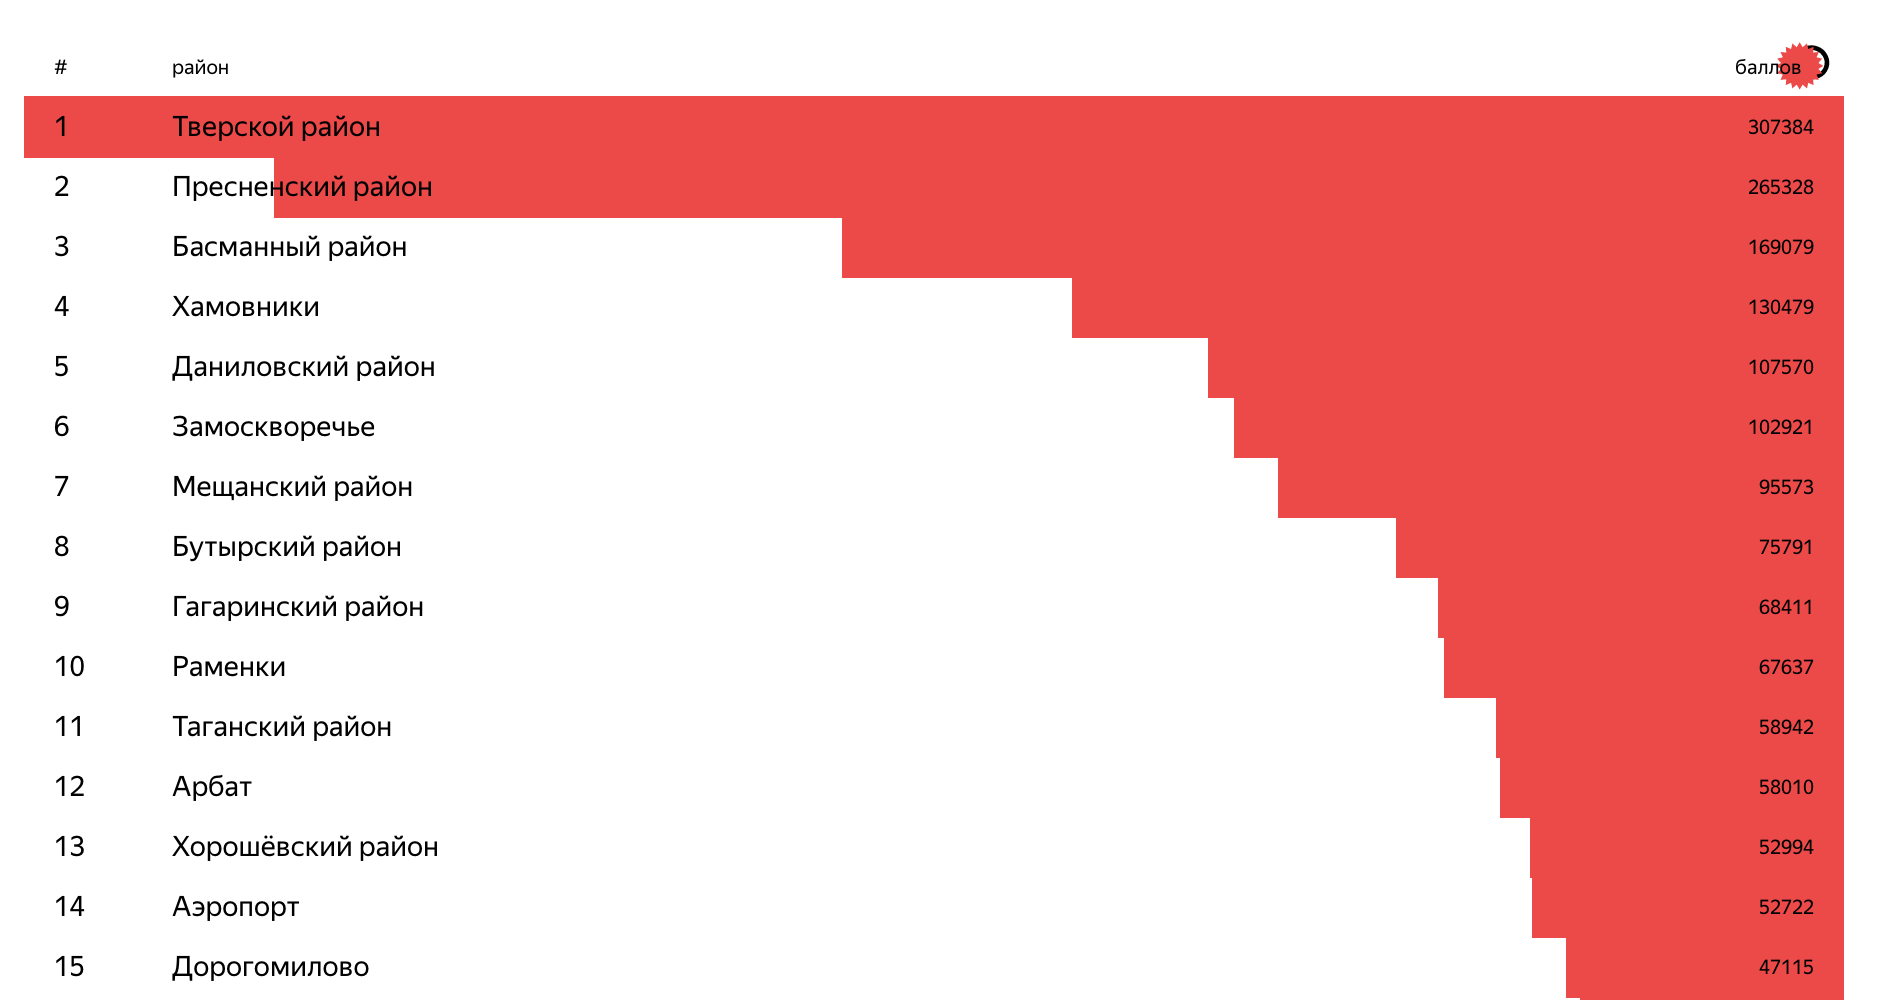
- удовлетворительные социальные отношения:
 - За это отвечает кол-во звонков по району (хотя оно рассчитано не очень точно, потому что данные есть только об административных округах)
- познание мира и развитие — доступ к знаниям
 - Этот пункт покрывается за счет данных об образовательных учреждениях
 
#### Этот анализ не покрывает следующие пункты:
- учёт мнения индивида при решении общественных проблем
 - На сегодняшний день все голосование так или иначе не требуют присутствия людей, например есть активный гражданин, это сервис который за счет голосования получает мнение горожан по актуальным вопросам. Государство всячески пытается мотивировать людей голосовать там, это происходит в онлайне, поэтому этот пункт можно не привязывать к определенному району
- комфортные условия труда
 - В целом на том же хранилище данных есть [информация](https://data.mos.ru/opendata/7704253064-otdely-trudoustroystva) об отделах трудоустройства, но она никак не привязана к районам. И на самом деле я не уверен что этим, действительно, кто-то пользуется, но это только исходя из моего личного опыта.

Так же еще есть один очень интересный датасет под назаванием "Аварийные службы по ремонту водопровода, канализации, освещения и отопления в многоквартирных домах". Это так же очень важно, поэтому я добавлю его в конечную формулу по рассчету качества жизни

In [386]:
urls['emergency_services']

{'url': 'https://op.mos.ru/EHDWSREST/catalog/export/get?id=402655',
 'format': 'xlsx',
 'description': 'Аварийные службы по ремонту водопровода, канализации, освещения и отопления в многоквартирных домах'}

In [387]:
emergency = get_data(
    urls['emergency_services']['url'],
    to_json=False,
    decode=False
)
df_emergency = pd.read_excel(BytesIO(emergency))
df_emergency.shape

(1048, 13)

In [397]:
df = df.set_index('District').join(
    df_emergency[['District', 'Name']].groupby('District').count().rename({'Name': 'emergencyCount'}, axis=1),
    how='left'
).reset_index()

In [398]:
df['qualityLifeA_Emergency'] = (df['emergencyCount'].values + df['SwimCount'].values + df['ChildClinicCount'].values + df['educCount'].values + df['FoodCount'].values) / df['CallsDistrict'].values

In [405]:
df.sort_values('qualityLifeA_Emergency', ascending=False).District.head(10)

54       Пресненский район
58          Тверской район
53         Басманный район
74       Даниловский район
6        Хорошёвский район
51     район Замоскворечье
50         Таганский район
52         район Хамовники
55         Мещанский район
110          район Раменки
Name: District, dtype: object

## Простроить интегральный показатель качества жизни, который бы позволил нивелировать колебания данных внутри года
Этот пункт относится только к временным данным, а у нас это только данные "Данные о вызовах пожарно-спасательного гарнизона". Я уже применил метод по сумме показателей, когда рассчитывал данные для этого датасета

In [452]:
def calc_quality_life(address: str):
    district = detect_district(address, regions)
    if len(district) == 0:
        return 'Cant find this address'
    elif len(district) > 1:
        print(district, '\n Please choose ur district (type index from 0)')
        index = input()
        district = district[int(index)]
    else:
        district = district[0]
    data = df[df.District == district].to_dict(orient='records')[-1]
    for i in ['qualityLife', 'qualityLifeActivity', 'qualityLifeA_Emergency']:
        print('{0!s} - {1!s}'.format(i, data[i]))
        
    place_top = df.sort_values('qualityLifeA_Emergency', ascending=False).District.tolist().index(district) + 1
    
    print('Ranking by quality with activity and emergency {0!s} out of {1!s}'.format(place_top, df.shape[0]))

In [453]:
calc_quality_life('Домодедовская, 44')

qualityLife - 0.030328331264808755
qualityLifeActivity - 0.031050434390161346
qualityLifeA_Emergency - 0.03502200157960059
Ranking by quality with activity and emergency 74 out of 128


In [454]:
calc_quality_life('Мытная, 66')

['район Якиманка', 'Даниловский район'] 
 Please choose ur district (type index from 0)
1
qualityLife - 0.17619316258603182
qualityLifeActivity - 0.17980367821279478
qualityLifeA_Emergency - 0.1834141938395577
Ranking by quality with activity and emergency 4 out of 128


## Итог


В итоге получилась некая формула:

`Качество жизни района = (кол-во бассейнов + кол-во аварийных служб + кол-во детских поликлиник + точек общественного питания) / Относительная опасность района)`

Где данные относительной опасности района берутся из вызовов пожарно-спасательного гарнизона и нивелируются внутри года засчет интегрального показателя, так же усредняются к районом от административных округов, путем усреднения на каждый район (что не очень точно). Все остальные метрики привязаны к районам.

В итоге выше можно видеть функцию, в которую нужно ввести адрес, если у нее не получается определить точный район, то она спросит пользователя, после чего выдаст ему 3 метрики качества жизни.
 - qualityLife - это изначальная метрика, формула которой была указана в тестовом
 - qualityLifeActivity - это метрика, которая так же учитывает крытые бассейны в районах
 - qualityLifeA_Emergency - это метрика, которая помимо крытых бассейнов учитывает аварийные службы в районе

Так же функция покажет на каком месте в топе находится его район, чтобы было понятно что вообще значат эти цифры.
Конечная витрина данных представлена ниже, там уже рассчитаны все метрики по районам и данные, на основе которых эти метрики рассчитывались.
Все данные подтягиваются в реальном времени из онлайна и не сохраняются на жесткий диск.

Эту метрику можно "кастомизировать", расставить веса каждому фактому, например пользователю будет очень важно, чтобы в районе были места для активного образа жизни (у меня это представлено только в качестве крытых бассейнов), так вот можно поставить вес этому фактору и конечный рейтинг районов изменится. (сейчас все факторы стоят с весом 1)

Так же для рассчета качества жизни еще необходимы данные по трудовой занятости, мне кажется это можно отследить черещ поездки, например то что человек в определенные часы куда-то едет (к сожалению в открытых данных я такого не нашел, да и вряд ли будут открывать данные по загруженности станции/автобусных остановках)

In [456]:
df.head()

,District,ChildClinicCount,educCount,FoodCount,CallsDistrict,AdmArea,AdmAreaCalls,qualityLife,SwimCount,qualityLifeActivity,emergencyCount,qualityLifeA_Emergency
0,район Матушкино,1.0,4,57,2084.800000,Зеленоградский административный округ,10424.0,0.029739,1.0,0.030219,3.0,0.031658
1,район Крюково,1.0,6,79,2084.800000,Зеленоградский административный округ,10424.0,0.041251,1.0,0.041731,9.0,0.046048
2,район Савёлки,1.0,3,43,2084.800000,Зеленоградский административный округ,10424.0,0.022544,2.0,0.023503,3.0,0.024942
3,район Старое Крюково,1.0,5,23,2084.800000,Зеленоградский административный округ,10424.0,0.013910,2.0,0.014870,3.0,0.016309
4,Ломоносовский район,2.0,10,65,2697.666667,Юго-Западный административный округ,32372.0,0.028543,3.0,0.029655,9.0,0.032991
